In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
import public_timeseries_testing_util as optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [3]:
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    if counter == 1:
        #print(test.head(3))
        #print(revealed_targets.head(3))
        print(sample_prediction)#.head(3))
    sample_prediction['target'] = 0
    env.predict(sample_prediction)
    counter += 1

         row_id  target
0      478_10_0       1
1      478_10_1       1
2      478_10_2       1
3      478_10_3       1
4      478_10_4       1
..          ...     ...
195  478_10_195       1
196  478_10_196       1
197  478_10_197       1
198  478_10_198       1
199  478_10_199       1

[200 rows x 2 columns]


In [55]:
# load
with open('stock_0.pickle', 'rb') as f:
    stock_0 = pickle.load(f)
    
#load
with open('train.pickle', 'rb') as f:
    train_data = pickle.load(f)

In [5]:
stock_0

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
191,0,0,10,1299772.70,1,1.000026,15261106.63,NaN,NaN,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0
382,0,0,20,1299772.70,1,0.999919,15261106.63,NaN,NaN,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0
573,0,0,30,1299772.70,1,1.000133,15261106.63,NaN,NaN,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0
764,0,0,40,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236980,0,480,500,0.00,0,0.999017,42161928.97,0.999017,0.999017,0.999017,53827.20,0.999193,146071.08,0.999065,3.999472,26450,480_500_0
5237180,0,480,510,0.00,0,0.998842,42161928.97,0.998842,0.998842,0.998842,157865.40,0.999017,120926.08,0.998941,3.190041,26451,480_510_0
5237380,0,480,520,475513.69,-1,0.999193,41686415.27,0.999017,0.999017,0.999193,57596.67,0.999368,46780.58,0.999289,-0.169873,26452,480_520_0
5237580,0,480,530,475513.69,-1,0.999193,41686415.27,0.999017,0.999017,0.999193,156610.53,0.999368,122677.94,0.999291,3.110170,26453,480_530_0


In [6]:
def genearte_p_matrix(state_matrix, q, lag=1):
    state_list = np.array([])
    #state_list = np.append(state_list, 1)
    for i in range(len(state_matrix)):
        target = state_matrix.iloc[i].values[0]
        #print(target, type(target))
        if target <= q[0] :
            state = 5
        elif target >= q[4] :
            state = 4
        elif target > q[0] and target <= q[1] :
            state = 3
        elif target > q[1] and target <= q[2] :
            state = 1
        elif target > q[2] and target <= q[3] :
            state = 0
        elif target > q[3] and target < q[4] :
            state = 2
        state_list = np.append(state_list, state)

    state_matrix['state_i'] = state_list
    state_matrix['state_j'] = state_matrix.state_i.shift(-lag)
    state_matrix = state_matrix.drop(columns=['target'])
    state_matrix = state_matrix.dropna()

    p_matrix_0 = []
    state = [0,1,2,3,4,5]

    for i in state:
        #print(i)
        p_row = []
        denominator = state_matrix.state_i.value_counts().sort_index().values[i] # the number of state i
        sum_num = 0
        for j in state:
            numerator = len(state_matrix.query(f'state_i == {i} and state_j =={j}'))
            sum_num += numerator
            conditional_prob = numerator/denominator
            p_row.append(round(conditional_prob,2))
        
        #print(denominator, sum_num)
        #print(sum(np.array(p_row)))
        
        p_matrix_0.append(p_row)
    
    p_matrix_0 = np.array(p_matrix_0)
    
    return p_matrix_0, q

In [7]:
state_matrix_0 = pd.DataFrame()
state_matrix_0['target'] = stock_0.target
state_matrix_0 = state_matrix_0.reset_index(drop=True)

In [8]:
q = (-20, -5, 0, 5, 20)
for i in range(1,10):
    p_matrix = genearte_p_matrix(state_matrix_0, q, i)
    print('For', p_matrix[1],':\n', p_matrix[0]*100)

For (-20, -5, 0, 5, 20) :
 [[58. 26. 13.  2.  0.  0.]
 [26. 57.  2. 14.  0.  0.]
 [31.  6. 61.  1.  1.  0.]
 [ 5. 29.  1. 64.  0.  1.]
 [ 6.  1. 50.  1. 42.  0.]
 [ 1.  3.  2. 40.  0. 55.]]
For (-20, -5, 0, 5, 20) :
 [[48. 31. 16.  6.  0.  0.]
 [30. 48.  6. 17.  0.  0.]
 [36. 12. 47.  3.  1.  0.]
 [12. 34.  3. 50.  0.  1.]
 [ 7.  8. 57.  1. 26.  1.]
 [ 5.  4.  5. 44.  0. 42.]]
For (-20, -5, 0, 5, 20) :
 [[42. 33. 16.  9.  0.  0.]
 [32. 41.  8. 18.  0.  0.]
 [38. 18. 36.  6.  1.  0.]
 [17. 35.  6. 40.  0.  1.]
 [16. 14. 58.  2.  9.  1.]
 [ 7. 15.  6. 43.  2. 28.]]
For (-20, -5, 0, 5, 20) :
 [[40. 33. 15. 11.  0.  0.]
 [32. 39. 11. 17.  0.  0.]
 [37. 24. 28. 10.  1.  0.]
 [23. 34. 10. 32.  0.  1.]
 [18. 18. 51.  6.  5.  2.]
 [12. 22. 10. 37.  2. 17.]]
For (-20, -5, 0, 5, 20) :
 [[37. 34. 15. 14.  0.  0.]
 [33. 37. 13. 16.  0.  0.]
 [35. 28. 22. 14.  1.  1.]
 [28. 32. 13. 26.  0.  1.]
 [19. 25. 40. 12.  0.  3.]
 [14. 21. 19. 35.  3.  8.]]
For (-20, -5, 0, 5, 20) :
 [[35. 36. 14. 15.  0.  

In [9]:
p_matrix = genearte_p_matrix(state_matrix_0, q, 1600)
print('For', p_matrix[1],':\n', p_matrix[0]*100)

For (-20, -5, 0, 5, 20) :
 [[33. 34. 16. 16.  0.  0.]
 [34. 34. 15. 17.  0.  0.]
 [34. 33. 15. 18.  0.  0.]
 [32. 33. 15. 19.  1.  1.]
 [22. 34. 22. 22.  0.  0.]
 [28. 21. 28. 21.  1.  2.]]


In [10]:
# Target Delta

state_matrix_0 = pd.DataFrame()
state_matrix_0['target_i'] = stock_0.target
state_matrix_0 = state_matrix_0.reset_index(drop=True)
state_matrix_0['target_j'] = state_matrix_0.shift(-1)
state_matrix_0 = state_matrix_0.dropna()

state_matrix_0['delta'] = state_matrix_0['target_i'] - state_matrix_0['target_j']
state_matrix_0 = state_matrix_0.drop(columns=['target_i', 'target_j'])

In [11]:
state_matrix_0

,delta
0,-3.419518
1,-3.830195
2,-1.230240
3,2.280474
4,2.570152
...,...
26449,-2.529621
26450,0.809431
26451,3.359914
26452,-3.280044


<Axes: >

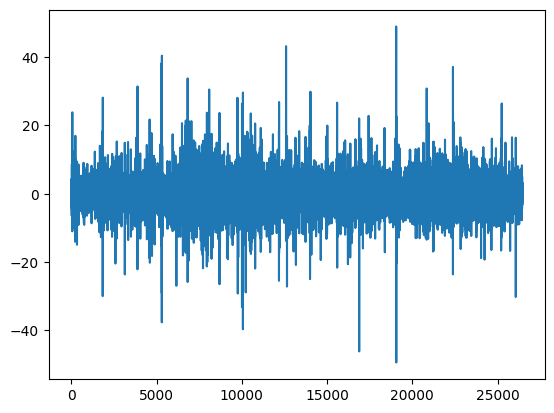

In [12]:
state_matrix_0.delta.plot()

In [122]:
q1 = float(state_matrix_0.delta.quantile(q=0.01, interpolation='nearest'))
q2 = float(state_matrix_0.delta.quantile(q=0.05, interpolation='nearest'))
q3 = float(state_matrix_0.delta.quantile(q=0.5, interpolation='nearest'))
q4 = float(state_matrix_0.delta.quantile(q=0.95, interpolation='nearest'))
q5 = float(state_matrix_0.delta.quantile(q=0.99, interpolation='nearest'))
q = (q1,q2,q3,q4,q5)

In [133]:
def genearte_delta_p_matrix(state_matrix, q, lag=1):
    state_list = np.array([])
    #state_list = np.append(state_list, 1)
    for i in range(len(state_matrix)):
        target = state_matrix.iloc[i].values[0]
        #print(target, type(target))
        if target <= q[0] :
            state = 5
        elif target >= q[4] :
            state = 4
        elif target > q[0] and target <= q[1] :
            state = 3
        elif target > q[1] and target <= q[2] :
            state = 1
        elif target > q[2] and target <= q[3] :
            state = 0
        elif target > q[3] and target < q[4] :
            state = 2
        state_list = np.append(state_list, state)

    state_matrix['delta_i'] = state_list
    #print(state_matrix)
    state_matrix['delta_j'] = state_matrix['delta_i'].shift(-lag)
    state_matrix = state_matrix.drop(columns=['delta'])
    state_matrix = state_matrix.dropna()

    p_matrix_0 = []
    state = [0,1,2,3,4,5]

    for i in state:
        #print(i)
        p_row = []
        denominator = state_matrix.delta_i.value_counts().sort_index().values[i] # the number of state i
        sum_num = 0
        for j in state:
            numerator = len(state_matrix.query(f'delta_i == {i} and delta_j =={j}'))
            sum_num += numerator
            conditional_prob = numerator/denominator
            p_row.append(round(conditional_prob,2))
        
        #print(denominator, sum_num)
        #print(sum(np.array(p_row)))
        
        p_matrix_0.append(p_row)
    
    p_matrix_0 = np.array(p_matrix_0)
    
    return p_matrix_0, q

In [134]:
for i in range(1,10):
    p_matrix = genearte_delta_p_matrix(state_matrix_0, q, i)
    print('For', p_matrix[1],':\n', p_matrix[0]*100)

For (-10.6298925, -5.9300660999999995, -0.010728819999999972, 5.9300663, 10.7204911) :
 [[45. 47.  4.  3.  1.  1.]
 [47. 45.  4.  4.  1.  1.]
 [38. 44.  6.  8.  1.  3.]
 [42. 40.  8.  6.  2.  2.]
 [26. 34.  5. 20.  5. 10.]
 [37. 27. 12.  8. 12.  4.]]
For (-10.6298925, -5.9300660999999995, -0.010728819999999972, 5.9300663, 10.7204911) :
 [[45. 46.  4.  4.  1.  1.]
 [46. 45.  4.  4.  1.  1.]
 [41. 44.  5.  6.  2.  2.]
 [42. 40.  8.  7.  2.  2.]
 [30. 43.  8. 10.  3.  6.]
 [43. 31.  9.  9.  5.  3.]]
For (-10.6298925, -5.9300660999999995, -0.010728819999999972, 5.9300663, 10.7204911) :
 [[45. 45.  4.  4.  1.  1.]
 [46. 45.  4.  4.  1.  1.]
 [42. 44.  4.  6.  2.  2.]
 [41. 44.  7.  5.  1.  2.]
 [35. 42.  8.  9.  2.  4.]
 [39. 40.  6.  7.  3.  3.]]
For (-10.6298925, -5.9300660999999995, -0.010728819999999972, 5.9300663, 10.7204911) :
 [[45. 45.  4.  4.  1.  1.]
 [45. 45.  4.  4.  1.  1.]
 [43. 42.  6.  5.  2.  2.]
 [42. 42.  7.  6.  2.  1.]
 [36. 44.  5. 10.  2.  3.]
 [37. 42.  8.  8.  2.  3

In [135]:
p_matrix = genearte_delta_p_matrix(state_matrix_0, q, 1600)
print('For', p_matrix[1],':\n', p_matrix[0]*100)

For (-10.6298925, -5.9300660999999995, -0.010728819999999972, 5.9300663, 10.7204911) :
 [[45. 45.  4.  4.  1.  1.]
 [45. 45.  4.  4.  1.  1.]
 [44. 46.  3.  5.  1.  1.]
 [46. 45.  3.  3.  1.  1.]
 [44. 45.  6.  4.  0.  1.]
 [44. 46.  5.  3.  0.  2.]]


In [195]:
df1 = pd.DataFrame()
df1['wap'] = stock_0['wap']
df1['wap_60'] = stock_0['wap'].shift(-6)
df1['wap_ratio'] = df1['wap_60']/df1['wap']
df1['target'] = stock_0['target']
df1 = df1.dropna()

In [13]:
stock_0

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
191,0,0,10,1299772.70,1,1.000026,15261106.63,NaN,NaN,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0
382,0,0,20,1299772.70,1,0.999919,15261106.63,NaN,NaN,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0
573,0,0,30,1299772.70,1,1.000133,15261106.63,NaN,NaN,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0
764,0,0,40,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236980,0,480,500,0.00,0,0.999017,42161928.97,0.999017,0.999017,0.999017,53827.20,0.999193,146071.08,0.999065,3.999472,26450,480_500_0
5237180,0,480,510,0.00,0,0.998842,42161928.97,0.998842,0.998842,0.998842,157865.40,0.999017,120926.08,0.998941,3.190041,26451,480_510_0
5237380,0,480,520,475513.69,-1,0.999193,41686415.27,0.999017,0.999017,0.999193,57596.67,0.999368,46780.58,0.999289,-0.169873,26452,480_520_0
5237580,0,480,530,475513.69,-1,0.999193,41686415.27,0.999017,0.999017,0.999193,156610.53,0.999368,122677.94,0.999291,3.110170,26453,480_530_0


In [19]:
index_df = pd.DataFrame()
index_df['date_id'] = stock_0['date_id']
index_df['seconds_in_bucket'] = stock_0['seconds_in_bucket']
index_df['index'] = np.NaN
index_df

,date_id,seconds_in_bucket,index
0,0,0,NaN
191,0,10,NaN
382,0,20,NaN
573,0,30,NaN
764,0,40,NaN
...,...,...,...
5236980,480,500,NaN
5237180,480,510,NaN
5237380,480,520,NaN
5237580,480,530,NaN


In [20]:
# load
with open('index.pickle', 'rb') as f:
    index_list = pickle.load(f)

In [21]:
index_df['index'] = index_list

In [22]:
df1 = pd.DataFrame()
df1['wap'] = stock_0['wap']
df1['wap_60'] = stock_0['wap'].shift(-6)
df1['wap_ratio'] = df1['wap_60']/df1['wap']
df1['target'] = stock_0['target']

df1['index'] = index_df['index']
df1['index_60'] = index_df['index'].shift(-6)
df1['index_ratio'] = df1['index_60']/df1['index']

df1['expect'] = (df1['wap_ratio']-df1['index_ratio'])*10000
df1 = df1.dropna()
df1

,wap,wap_60,wap_ratio,target,index,index_60,index_ratio,expect
0,1.000000,1.000517,1.000517,-3.029704,1.000000,1.000756,1.000756,-2.390733
191,0.999892,1.000421,1.000529,0.389814,1.000403,1.000811,1.000408,1.207033
382,0.999842,1.000148,1.000306,4.220009,1.000527,1.000414,0.999887,4.185493
573,1.000085,1.000426,1.000341,5.450249,1.000534,1.000296,0.999762,5.788179
764,1.000317,1.000261,0.999944,3.169775,1.000584,1.000207,0.999622,3.216662
...,...,...,...,...,...,...,...,...
5235780,0.998678,0.999065,1.000388,4.440546,0.999231,0.999154,0.999922,4.650919
5235980,0.998912,0.998941,1.000029,-0.609756,0.999127,0.999196,1.000069,-0.403390
5236180,0.999429,0.999289,0.999860,-0.640154,0.999178,0.999123,0.999945,-0.853199
5236380,0.999294,0.999291,0.999997,0.139475,0.999134,0.999128,0.999994,0.030882


In [30]:
stock_0

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
191,0,0,10,1299772.70,1,1.000026,15261106.63,NaN,NaN,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0
382,0,0,20,1299772.70,1,0.999919,15261106.63,NaN,NaN,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0
573,0,0,30,1299772.70,1,1.000133,15261106.63,NaN,NaN,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0
764,0,0,40,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236980,0,480,500,0.00,0,0.999017,42161928.97,0.999017,0.999017,0.999017,53827.20,0.999193,146071.08,0.999065,3.999472,26450,480_500_0
5237180,0,480,510,0.00,0,0.998842,42161928.97,0.998842,0.998842,0.998842,157865.40,0.999017,120926.08,0.998941,3.190041,26451,480_510_0
5237380,0,480,520,475513.69,-1,0.999193,41686415.27,0.999017,0.999017,0.999193,57596.67,0.999368,46780.58,0.999289,-0.169873,26452,480_520_0
5237580,0,480,530,475513.69,-1,0.999193,41686415.27,0.999017,0.999017,0.999193,156610.53,0.999368,122677.94,0.999291,3.110170,26453,480_530_0


<Axes: >

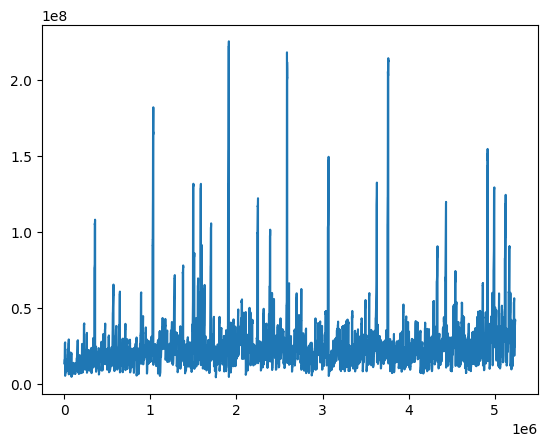

In [34]:
stock_0['matched_size'].plot()

In [33]:
df1[['target', 'expect']]

,target,expect
0,-3.029704,-2.390733
191,0.389814,1.207033
382,4.220009,4.185493
573,5.450249,5.788179
764,3.169775,3.216662
...,...,...
5235780,4.440546,4.650919
5235980,-0.609756,-0.403390
5236180,-0.640154,-0.853199
5236380,0.139475,0.030882


2.379613838700909


<Axes: >

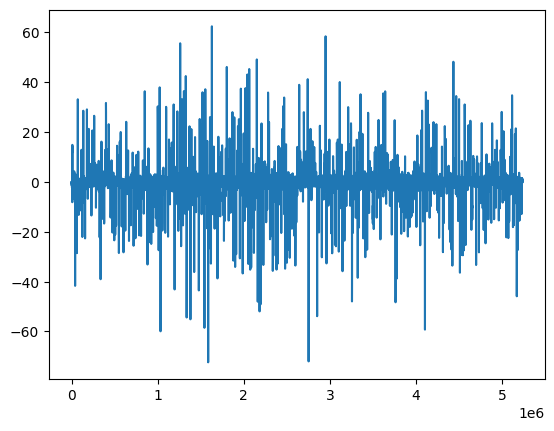

In [125]:
print(abs(df1['target'] - df1['expect']).mean())
(df1['target'] - df1['expect']).plot()

In [128]:
df2 = pd.DataFrame()
df2 = stock_0
df2[['target','expect']] = df1[['target','expect']]
df2['spread'] =  (df2['reference_price'] + df2['ask_price'] - df2['bid_price'])
df2['imbalance'] = df2['imbalance_buy_sell_flag'] * df2['imbalance_size']
df2['expect'] =df2['expect'] * df2['spread']
df2['error'] = df2['target'] - df2['expect']
df2 = df2.drop(columns=['stock_id', 'date_id', 'seconds_in_bucket', 'time_id', 'row_id'])
df2.corr()[['target','expect','error']]

,target,expect,error
imbalance_size,-0.050460,-0.037691,0.023113
imbalance_buy_sell_flag,-0.018904,-0.019503,0.015294
reference_price,-0.035548,-0.177129,0.201890
matched_size,-0.006438,0.044603,-0.057958
far_price,-0.042138,-0.040187,0.030777
near_price,-0.009171,-0.029932,0.029289
bid_price,-0.039988,-0.180503,0.203995
bid_size,-0.012734,0.003911,-0.010712
ask_price,-0.041185,-0.181807,0.205049
ask_size,0.028002,0.039259,-0.035437


2.379320552338036


<Axes: >

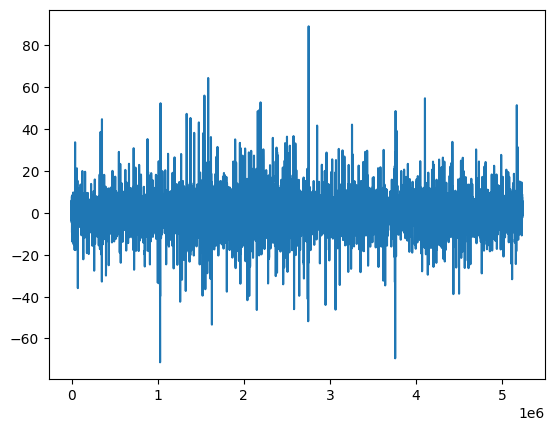

In [123]:
print(abs(df2['target'] - df2['expect']).mean())
(df2['target']-df2['error']).plot()

In [38]:
df1[['target','expect']].corr()

,target,expect
target,1.00000,0.64287
expect,0.64287,1.00000


In [23]:
df1[['target','expect']].corr()

,target,expect
target,1.00000,0.64287
expect,0.64287,1.00000


<Axes: >

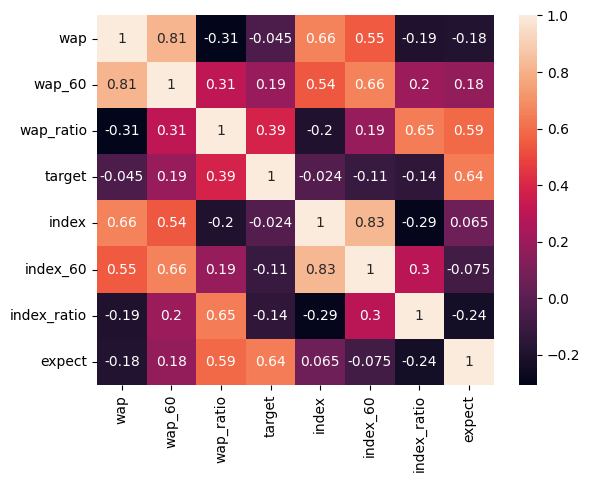

In [221]:
corr = df1.corr()
sns.heatmap(corr, annot=True)

In [192]:
stock_0['index'] = index_list

In [193]:
corr = stock_0.corr()
corr.target

stock_id                        NaN
date_id                    0.003436
seconds_in_bucket          0.012088
imbalance_size            -0.050500
imbalance_buy_sell_flag   -0.018919
reference_price           -0.035588
matched_size              -0.006370
far_price                 -0.042110
near_price                -0.009146
bid_price                 -0.040023
bid_size                  -0.012641
ask_price                 -0.041222
ask_size                   0.028147
wap                       -0.045338
target                     1.000000
time_id                    0.003461
row_id                    -0.000644
index                     -0.024121
Name: target, dtype: float64

In [150]:
corr = df1.corr()
corr.target

wap         -0.045302
wap_60       0.191360
wap_ratio    0.386071
target       1.000000
Name: target, dtype: float64

In [142]:
import seaborn as sns

<Axes: >

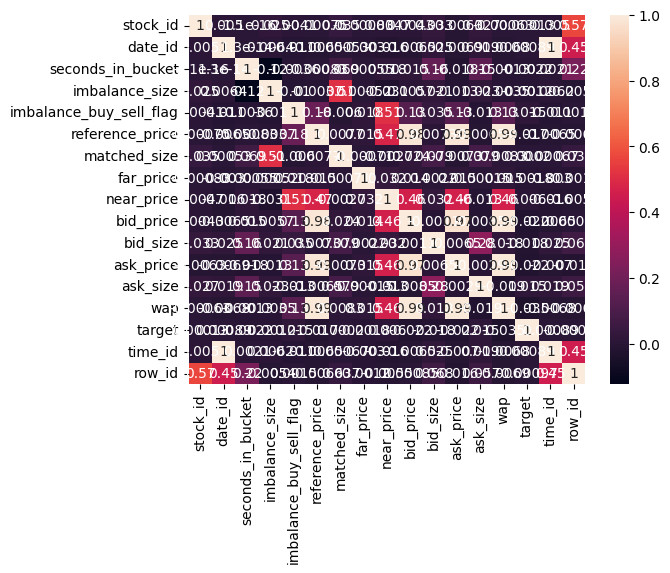

In [143]:
sns.heatmap(corr, annot=True)